# Install & Import Libraries

In [21]:
import os
import glob
import numpy as np
import pandas as pd
import time
import random
import tensorflow as tf
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model

# Parameters

In [23]:
sampling_rate = 20
window_size = 3 * sampling_rate  # 60 timesteps
wand_classes = ["Circle", "Infinity", "None", "Square", "Triangle", "Wave", "Zigzag"]
num_channels_online = 45
num_channels_wand = 6
batch_size = 16
epochs = 30
weight_decay = 1e-4

# Processing Functions

In [25]:
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff=5, fs=50, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return lfilter(b, a, data)

def normalize_window(window):
    return (window - np.mean(window, axis=0)) / (np.std(window, axis=0) + 1e-8)

def pad_or_crop(sample, window_size):
    n_rows, n_cols = sample.shape
    if n_rows > window_size:
        return sample[:window_size, :]
    elif n_rows < window_size:
        pad_width = ((0, window_size - n_rows), (0, 0))
        return np.pad(sample, pad_width, mode='constant')
    else:
        return sample

# Dataset loader

In [27]:
def load_preprocess_dataset(dataset_path, window_size=60, 
                                   selected_channels=None, class_list=None, use_labels_folder=True):
    """Load dataset and apply global normalization."""
    data_folder = os.path.join(dataset_path, "data_clean")
    X_list, y_list = [], []

    data_files = sorted(os.listdir(data_folder))

    if use_labels_folder:
        label_folder = os.path.join(dataset_path, "label")
        label_files = sorted(os.listdir(label_folder))
        for data_file, label_file in zip(data_files, label_files):
            arr = pd.read_csv(os.path.join(data_folder, data_file)).values
            if selected_channels:
                arr = arr[:, selected_channels]
            arr = pad_or_crop(arr, window_size)
            X_list.append(arr)

            with open(os.path.join(label_folder, label_file), 'r') as f:
                y_list.append(f.read().strip())
    else:
        for data_file in data_files:
            arr = pd.read_csv(os.path.join(data_folder, data_file)).values
            if selected_channels:
                arr = arr[:, selected_channels]
            arr = pad_or_crop(arr, window_size)
            X_list.append(arr)

            # Infer label from filename
            label = os.path.splitext(data_file)[0].split("_")[0].capitalize()
            y_list.append(label)

    X_stack = np.stack(X_list, axis=0)
    y = np.array(y_list)

    # Compute global mean/std over all windows
    all_data = X_stack.reshape(-1, X_stack.shape[2])
    channel_mean = all_data.mean(axis=0)
    channel_std = all_data.std(axis=0)
    channel_std[channel_std < 1e-6] = 1.0

    # Apply global normalization
    X_norm = (X_stack - channel_mean) / channel_std

    # Encode labels
    encoder = LabelEncoder()
    if class_list:
        encoder.fit(class_list)
    else:
        encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_onehot = np.eye(len(encoder.classes_))[y_encoded]

    print(f"Loaded {len(X_norm)} samples, {X_norm.shape[1]} timesteps, {X_norm.shape[2]} channels")
    print(f"Classes: {list(encoder.classes_)}")

    return X_norm, y_onehot, encoder, channel_mean, channel_std

# Train base model on online dataset

In [29]:
dataset_online_path = r"C:\Users\CK Cheong\Desktop\rosbag\data"
X_online, y_online, encoder_online, mean_online, std_online = load_preprocess_dataset(
    dataset_online_path,
    window_size=window_size,
    selected_channels=None,
    class_list=None,
    use_labels_folder=True
)

# Split for training/validation
X_train_online, X_val_online, y_train_online, y_val_online = train_test_split(
    X_online, y_online, test_size=0.2, stratify=y_online, random_state=42
)

Loaded 810 samples, 60 timesteps, 45 channels
Classes: ['label\n0', 'label\n1', 'label\n10', 'label\n2', 'label\n3', 'label\n4', 'label\n5', 'label\n6']


# Base CNN Model

In [31]:
base_model = Sequential([
    tf.keras.Input(shape=(window_size, num_channels_online)),
    
    Conv1D(32, 5, kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),  
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(64, 5, kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),  
    MaxPooling1D(2),
    Dropout(0.4),

    Conv1D(128, 3, kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),  
    MaxPooling1D(2),
    Dropout(0.4),
    
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(0.4),
    Dense(len(encoder_online.classes_), activation='softmax')
])

base_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

history_online = base_model.fit(
    X_train_online, y_train_online,
    validation_data=(X_val_online, y_val_online),
    epochs=30,
    batch_size=32
)

# Save base model
base_model.save("base_model_online.keras")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 56, 32)         │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,912 (202.78 KB)

 Trainable params: 51,464 (201.03 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.2392 - loss: 2.0538 - val_accuracy: 0.3395 - val_loss: 1.8168
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4074 - loss: 1.5789 - val_accuracy: 0.4877 - val_loss: 1.5700
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5139 - loss: 1.2878 - val_accuracy: 0.5926 - val_loss: 1.3450
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5988 - loss: 1.0829 - val_accuracy: 0.6790 - val_loss: 1.0868
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6620 - loss: 0.9063 - val_accuracy: 0.7160 - val_loss: 0.9003
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7052 - loss: 0.8509 - val_accuracy: 0.7654 - val_loss: 0.7521
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7515 - loss: 0.7140 - val_accuracy: 0.7469 - val_loss: 0.7023
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7840 - loss: 0.6464 - val_accuracy: 0.7778 - v

# Clean wand dataset and load

In [33]:
wand_dataset = r"C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset"

X_wand, y_wand, encoder_wand, mean_wand, std_wand = load_preprocess_dataset(
    wand_dataset,
    window_size=window_size,
    selected_channels=[0,1,2,3,4,5],
    class_list=wand_classes,
    use_labels_folder=False
)

Loaded 4738 samples, 60 timesteps, 6 channels
Classes: ['Circle', 'Infinity', 'None', 'Square', 'Triangle', 'Wave', 'Zigzag']


# Compute mean, std

In [35]:
# Split train/val 
X_train, X_val, y_train, y_val = train_test_split(
    X_wand, y_wand, test_size=0.2, stratify=y_wand, random_state=42
)

# Save the mean and std values to .npy (from loader)
np.save("mean_std.npy", {"mean": mean_wand, "std": std_wand})

data = np.load("mean_std.npy", allow_pickle=True).item()
mean = data["mean"]
std  = data["std"]

with open("mean_std.h", "w") as f:
    f.write("#ifndef MEAN_STD_H\n#define MEAN_STD_H\n\n")
    f.write("#include <cstdint>\n\n")

    f.write(f"const float channel_mean[{len(mean)}] = {{")
    f.write(", ".join(f"{m:.8f}" for m in mean))
    f.write("};\n")

    f.write(f"const float channel_std[{len(std)}] = {{")
    f.write(", ".join(f"{s:.8f}" for s in std))
    f.write("};\n\n")

    f.write("#endif // MEAN_STD_H\n")

print("mean_std.h generated successfully.")

mean_std.h generated successfully.


# Apply augmentation

In [37]:
def augment_window_tf(window, label):
    # Ensure window is float32
    window = tf.cast(window, tf.float32)  
    # Gaussian noise
    noise = tf.random.normal(shape=tf.shape(window), mean=0.0, stddev=0.01, dtype=tf.float32)
    # Random scale factor
    scale = tf.random.uniform([], 0.9, 1.1, dtype=tf.float32)
    # Random time shift
    shift = tf.random.uniform([], -3, 3, dtype=tf.int32)
    # Apply augmentations
    window = window + noise
    window = window * scale
    window = tf.roll(window, shift=shift, axis=0)
    
    return window, label

def make_dataset(X, y, batch_size=32, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), reshuffle_each_iteration=True)
        ds = ds.map(augment_window_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=16, training=True)
val_ds   = make_dataset(X_val, y_val, batch_size=16, training=False)

# Compute Class Weights (for balancing) 
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Use a fresh checkpoint filename to avoid conflicts with old models
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "cnn_wand_best_fresh.keras", monitor='val_accuracy',
    save_best_only=True, verbose=1
)

# Add learning rate reduction for better convergence
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

Class Weights: {0: 1.015813454837845, 1: 1.0679064525218371, 2: 1.0177228786251342, 3: 0.9898145729955602, 4: 0.9898145729955602, 5: 0.9668367346938775, 6: 0.9599797365754813}


# Simplified CNN Model

In [39]:
# Define number of classes
num_classes = len(wand_classes)

# Model with BatchNorm for training (will be folded after training)
simplified_model = Sequential([
    tf.keras.Input(shape=(window_size, num_channels_wand)),

    Conv1D(16, 3, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(2),
    
    Conv1D(24, 3, use_bias=False),   
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(2),
    
    GlobalAveragePooling1D(),
    Dense(24, activation='relu', use_bias=False),
    Dense(num_classes, activation='softmax', use_bias=True)
])

simplified_model.compile(
    optimizer=Adam(0.001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model 
# IMPORTANT: Delete old checkpoint files if they exist to avoid conflicts
if os.path.exists("cnn_simplified_wand_best.keras"):
    os.remove("cnn_simplified_wand_best.keras")
    print("Deleted old checkpoint file to avoid conflicts")

history_simplified = simplified_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr],  # Only checkpoint and learning rate reduction
    verbose=1
)

# Save Final Model (with BatchNorm)
simplified_model.save("cnn_simplified_wand_augmented.keras")

# Print training summary
print("\n" + "="*60)
print("TRAINING SUMMARY:")
print("="*60)
print(f"Best validation accuracy: {max(history_simplified.history['val_accuracy']):.4f} ({max(history_simplified.history['val_accuracy'])*100:.2f}%)")
print(f"Final validation accuracy: {history_simplified.history['val_accuracy'][-1]:.4f} ({history_simplified.history['val_accuracy'][-1]*100:.2f}%)")
print(f"Total epochs trained: {len(history_simplified.history['val_accuracy'])}")
print("="*60)

Epoch 1/100
235/237 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2518 - loss: 1.8594
Epoch 1: val_accuracy improved from None to 0.57278, saving model to cnn_wand_best_fresh.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3702 - loss: 1.7067 - val_accuracy: 0.5728 - val_loss: 1.4833 - learning_rate: 0.0010
Epoch 2/100
232/237 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5760 - loss: 1.3492
Epoch 2: val_accuracy improved from 0.57278 to 0.66456, saving model to cnn_wand_best_fresh.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5997 - loss: 1.2859 - val_accuracy: 0.6646 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 3/100
234/237 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6572 - loss: 1.1192
Epoch 3: val_accuracy improved from 0.66456 to 0.72574, saving model to cnn_wand_best_fresh.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6805 - loss: 1.0522 - val_accuracy: 0.7257 - val_loss: 0.9463 - learning_rate: 0.0010
Epoch 4/100
236/237 ━━

# BatchNorm Folding function

In [41]:
def fold_batchnorm_sequential(model: Sequential, input_shape):
    """
    Fold BatchNorm layers into the preceding Conv1D or Dense layers in a Sequential model.
    Works for any Sequential model. Returns a new Sequential model.
    input_shape: tuple of (timesteps, channels)
    """
    new_layers = []
    skip_next = False

    # Create dummy input to build layers dynamically
    dummy_input = np.zeros((1,) + input_shape, dtype=np.float32)

    for i, layer in enumerate(model.layers):
        if skip_next:
            skip_next = False
            continue

        # Check if next layer is BatchNorm
        if i + 1 < len(model.layers) and isinstance(model.layers[i + 1], BatchNormalization):
            bn = model.layers[i + 1]

            if isinstance(layer, (Conv1D, Dense)):
                # Get original weights
                W = layer.get_weights()[0]
                b = layer.get_weights()[1] if len(layer.get_weights()) > 1 else np.zeros(W.shape[-1])

                # Get BN params
                gamma, beta, mean, var = bn.get_weights()
                eps = bn.epsilon

                # Compute folded weights and bias
                scale = gamma / np.sqrt(var + eps)
                b_folded = beta + (b - mean) * scale

                if isinstance(layer, Conv1D):
                    W_folded = W * scale.reshape(1, 1, -1)
                else:  # Dense
                    W_folded = W * scale.reshape(1, -1)

                # Recreate layer with folded weights
                config = layer.get_config()
                config['use_bias'] = True
                new_layer = layer.__class__.from_config(config)

                # Build the layer by calling it on dummy input
                new_layer(dummy_input)
                new_layer.set_weights([W_folded, b_folded])

                # Update dummy input for next layer
                dummy_input = new_layer(dummy_input)

                new_layers.append(new_layer)
                skip_next = True  # skip BN layer
            else:
                # BN after non-foldable layer? keep both
                new_layers.append(layer)
                dummy_input = layer(dummy_input)
        else:
            # No BN next, just copy the layer
            new_layer = layer.__class__.from_config(layer.get_config())
            new_layer(dummy_input)
            if layer.get_weights():
                new_layer.set_weights(layer.get_weights())
            new_layers.append(new_layer)
            dummy_input = new_layer(dummy_input)

    return Sequential(new_layers)

# Apply BN folding to model

In [43]:
# Input shape: (timesteps, channels)
input_shape = (60, 6)

# Load original trained model
model = load_model("cnn_simplified_wand_augmented.keras")

# Fold BN into Conv/Dense layers
folded_model = fold_batchnorm_sequential(model, input_shape=(60,6))

# Build folded model by calling dummy input
dummy_input = np.zeros((1, 60, 6), dtype=np.float32)
folded_model(dummy_input)

# Save folded model safely
folded_model.save("folded_cnn_model.keras")

# Original model is untouched

# Evaluate simplified/folded model

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Simplified Model
              precision    recall  f1-score   support

      Circle       0.98      0.97      0.97       666
    Infinity       0.98      0.99      0.99       634
        None       0.97      0.97      0.97       665
      Square       0.99      0.99      0.99       684
    Triangle       0.98      0.98      0.98       684
        Wave       0.99      0.98      0.98       700
      Zigzag       0.99      0.99      0.99       705

    accuracy                           0.98      4738
   macro avg       0.98      0.98      0.98      4738
weighted avg       0.98      0.98      0.98      4738

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Folded Model
              precision    recall  f1-score   support

      Circle       0.98      0.97      0.97       666
    Infinity       0.98      0.99      0.99       634
        None       0.97      0.97      0.97       665
      Square       0.99      0.99      0.99       684
    Triangle       0

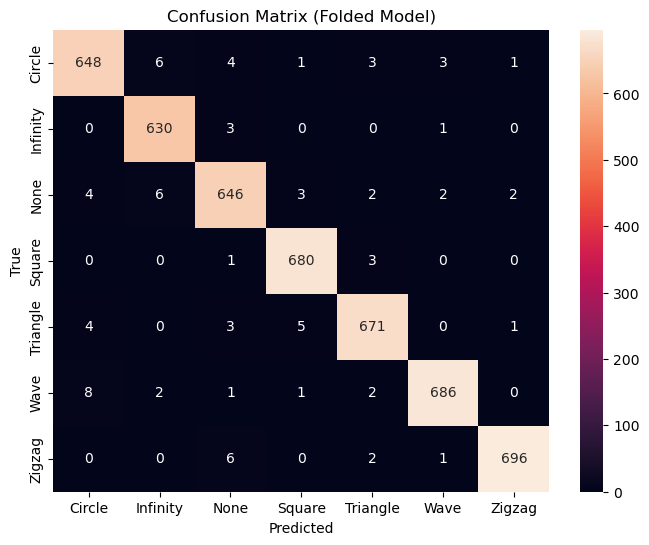

In [45]:
y_pred = simplified_model.predict(X_wand)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_wand, axis=1)

print("Simplified Model")
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=wand_classes,
    zero_division=0
))

y_pred = folded_model.predict(X_wand)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_wand, axis=1)

print("Folded Model")
print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=wand_classes,
    zero_division=0
))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=wand_classes, yticklabels=wand_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Folded Model)')
plt.show()

# Generate test data 

In [47]:
# Load your trained model
model = tf.keras.models.load_model("folded_cnn_model.keras")

# Parameters
num_samples = 10
window_size = 60
num_channels_wand = 6
num_classes = 7
clean_dir = r"C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset\data_clean"

# Load and preprocess test windows
def load_test_windows(num_samples=num_samples):
    files = sorted(glob.glob(os.path.join(clean_dir, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {clean_dir}")

    # Group files by class
    class_to_files = {}
    for f in files:
        label = os.path.basename(f).split("_")[0].capitalize()
        class_to_files.setdefault(label, []).append(f)

    class_names = list(class_to_files.keys())
    num_classes_found = len(class_names)
    print(f"Found {num_classes_found} classes:", class_names)

    if num_classes_found == 0:
        raise ValueError("No classes found in directory")

    # Ensure at least one per class (if possible)
    samples_per_class = {cls: 1 for cls in class_names}
    remaining = num_samples - num_classes_found

    # Distribute remaining samples proportionally to number of available files
    total_files = sum(len(v) for v in class_to_files.values())
    for cls in class_names:
        if remaining <= 0:
            break
        cls_fraction = len(class_to_files[cls]) / total_files
        add = int(round(cls_fraction * remaining))
        samples_per_class[cls] += add

    # Adjust if rounding causes overflow/underflow
    total_assigned = sum(samples_per_class.values())
    while total_assigned > num_samples:
        reducible = [c for c, n in samples_per_class.items() if n > 1]
        if not reducible:
            break
        cls = random.choice(reducible)
        samples_per_class[cls] -= 1
        total_assigned -= 1

    while total_assigned < num_samples:
        cls = random.choice(class_names)
        samples_per_class[cls] += 1
        total_assigned += 1

    X, labels = [], []

    # Sample and preprocess
    for cls, n_samples in samples_per_class.items():
        class_files = class_to_files[cls]
        random.shuffle(class_files)
        chosen_files = class_files[:n_samples]

        for f in chosen_files:
            df = pd.read_csv(f)
            arr = df.values.astype(np.float32)

            # Adjust number of channels
            if arr.shape[1] != num_channels_wand:
                if arr.shape[1] > num_channels_wand:
                    arr = arr[:, -num_channels_wand:]
                else:
                    print("Skipping (wrong #cols):", f)
                    continue

            # Pad or crop to window size
            if arr.shape[0] > window_size:
                arr = arr[:window_size, :]
            elif arr.shape[0] < window_size:
                pad = np.zeros((window_size - arr.shape[0], arr.shape[1]), dtype=np.float32)
                arr = np.vstack([arr, pad])

            arr = (arr - mean_wand) / std_wand

            X.append(arr)
            labels.append(cls)

    X = np.stack(X, axis=0)
    return X, labels, class_names

x_test, y_labels, class_names = load_test_windows(num_samples)

# 2. Predict
y_pred = model.predict(x_test, verbose=0)
pred_classes = np.argmax(y_pred, axis=1)

print("Predicted classes:", pred_classes)
print("True labels:", y_labels)

Found 7 classes: ['Circle', 'Infinity', 'None', 'Square', 'Triangle', 'Wave', 'Zigzag']
Predicted classes: [0 1 2 3 4 4 5 6 6 6]
True labels: ['Circle', 'Infinity', 'None', 'Square', 'Triangle', 'Triangle', 'Wave', 'Zigzag', 'Zigzag', 'Zigzag']


# Extract Test Data and Weights

In [49]:
with open("test_data.h", "w") as f:
    f.write("/* Test dataset from Keras CNN (float32) */\n")
    f.write("#ifndef TEST_DATA_H\n#define TEST_DATA_H\n\n")
    f.write("#include <cstdint>\n\n")
    f.write(f"#define NUM_SAMPLES {x_test.shape[0]}\n")
    f.write(f"#define INPUT_LEN {window_size}\n")
    f.write(f"#define INPUT_CH {num_channels_wand}\n")
    f.write(f"#define NUM_CLASSES {num_classes}\n\n")

    # Input array
    f.write(f"const float test_inputs[NUM_SAMPLES][INPUT_LEN][INPUT_CH] = {{\n")
    for n in range(x_test.shape[0]):
        f.write("  {\n")
        for t in range(window_size):
            row = ", ".join(map(lambda v: f"{v:.6f}", x_test[n, t]))
            f.write(f"    {{{row}}},\n")
        f.write("  },\n")
    f.write("};\n\n")

    # Output array
    f.write(f"const float test_outputs[NUM_SAMPLES][NUM_CLASSES] = {{\n")
    for n in range(y_pred.shape[0]):
        row = ", ".join(map(lambda v: f"{v:.6f}", y_pred[n]))
        f.write(f"  {{{row}}},\n")
    f.write("};\n\n")

    f.write("#endif // TEST_DATA_H\n")

with open("cnn_weights.h", "w") as f:
    f.write("// CNN weights (float32)\n\n")
    f.write("#include <cstdint>\n\n")

    for layer in model.layers:
        weights = layer.get_weights()
        if not weights:
            continue

        f.write(f"// Layer: {layer.name}\n")

        for i, w in enumerate(weights):
            if len(w.shape) == 3:  # Conv1D: (kernel, in, out)
                w = np.transpose(w, (2, 1, 0))  # (out, in, k)
            # Dense or Bias remain as-is

            flat = w.flatten().astype(np.float32)
            name = f"{layer.name}_param{i}"
            f.write(f"const float {name}[{len(flat)}] = {{\n")
            f.write(", ".join(map(lambda v: f"{v:.6f}", flat)))
            f.write("\n};\n\n")

    f.write("// End of cnn_weights.h\n")

print("Test data and weights exported as float32.")

Test data and weights exported as float32.
